<a href="https://colab.research.google.com/github/faithrts/COMP-551/blob/faith-branch-testing/A3_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-up

In [1]:
### importing libraries and setting the random seed

import numpy as np
import pandas as pd
import sys

%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
#from matplotlib import cm

import re
import math
from importlib import reload
from typing import List
from tqdm import tqdm
from enum import Enum
from numpy.random import RandomState

from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1234)
random_state = RandomState(1234)

# a folder to store the saved graphs
!mkdir images

# Data Handling

### Helper functions

#### Loading and cleaning data

In [2]:
# assumes the last column of the dataframe is the labels
def x_y_from_df(df):
  x = df.iloc[:, :-1].to_numpy()
  y = df.iloc[:, -1].to_numpy()

  return x, y

In [3]:
def center_array(arr):
  mean = np.mean(arr)
  return_arr = np.array(arr) - mean
  # return_arr = [item - mean for item in arr]

  return return_arr

In [4]:
def normalize_array(arr):
  std = np.std(arr)
  return_arr = np.array(arr) / std
  # return_arr = [item / std for item in arr]

  return return_arr

In [5]:
# pre-processes the df by performing mean subtraction and normalization
def preprocess_df(df):
  preprocessed_df = df.copy()

  for col in preprocessed_df.iloc[:, :-1]:
    preprocessed_col = normalize_array(center_array(df[col]))
    preprocessed_df[col] = preprocessed_col

  return preprocessed_df

#### Plotting graphs

In [6]:
def plot_label_distributions(label_arr, dataset_name, labels = 0):
  
  # creates the plot
  plt.figure(figsize = (10,4))
  width = 0.6

  unique_labels = list(set(label_arr))
  counts = []

  for label in unique_labels:
    count = label_arr.count(label)
    counts.append(count)

  if labels == 0:
    labels = [str(label) for label in unique_labels]

  # the colour codes of the bars
  colours = ['#001219', '#005f73', '#0a9396', '#94d2bd', '#e9d8a6',
            '#ee9b00', '#ca6702', '#bb3e03', '#ae2012', '#9b2226']

  plt.bar(labels, counts, width, color = colours)
  plt.title("Distribution of Class Labels in " + dataset_name + " Dataset")
  plt.xlabel("Label")
  plt.ylabel("Count")

  for index, value in enumerate(counts):
    plt.text(index - 0.24, value + 5, str(round(value, 2)))

  plt.show()

## Importing

In [7]:
# clones the github repo
!git clone https://github.com/zalandoresearch/fashion-mnist
sys.path.insert(1, 'fashion-mnist/utils')

# imports the mnist reader from the repo
import mnist_reader

Cloning into 'fashion-mnist'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 762 (delta 0), reused 3 (delta 0), pack-reused 758
Receiving objects: 100% (762/762), 105.85 MiB | 16.56 MiB/s, done.
Resolving deltas: 100% (444/444), done.


### Loading and cleaning data

In [8]:
### loading the data using the github repo's mnist_reader.load_mnist

labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# training data
x_train_temp, y_train = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind = 'train')

# testing data
x_test_temp, y_test = mnist_reader.load_mnist('fashion-mnist/data/fashion', kind = 't10k')

In [9]:
### creating dataframes to better understand data

# training dataframe
train_temp_df = pd.DataFrame(x_train_temp)
train_temp_df['LABEL'] = y_train

# testing dataframe
test_temp_df = pd.DataFrame(x_test_temp)
test_temp_df['LABEL'] = y_test

In [10]:
train_temp_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,LABEL
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9
1,0,0,0,0,0,1,0,0,0,0,...,114,130,76,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
59996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
59997,0,0,0,0,0,0,0,0,0,5,...,0,0,0,0,0,0,0,0,0,3
59998,0,0,0,0,0,0,0,0,0,0,...,54,50,5,0,1,0,0,0,0,0


In [11]:
### centering and normalizing the data

# pre-processing each dataframe
train_df = preprocess_df(train_temp_df)
test_df = preprocess_df(test_temp_df)

# extracting arrays for x_train, y_train, x_test, y_test
x_train, y_train = x_y_from_df(train_df)
x_test, y_test = x_y_from_df(test_df)

In [12]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,LABEL
0,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,9
1,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,0.100437,-0.098878,-0.156653,-0.239080,-0.377827,...,1.857395,2.697741,1.324682,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
2,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,0.198023,...,-0.474798,-0.370475,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
3,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,1.145393,2.134974,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,3
4,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,5
59996,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,1
59997,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.246952,...,-0.474798,-0.394260,-0.406094,-0.441358,-0.396626,-0.288156,-0.156811,-0.089673,-0.034147,3
59998,-0.008644,-0.023223,-0.039178,-0.041322,-0.057646,-0.071167,-0.098878,-0.156653,-0.239080,-0.377827,...,0.629925,0.794971,-0.292227,-0.441358,-0.374489,-0.288156,-0.156811,-0.089673,-0.034147,0


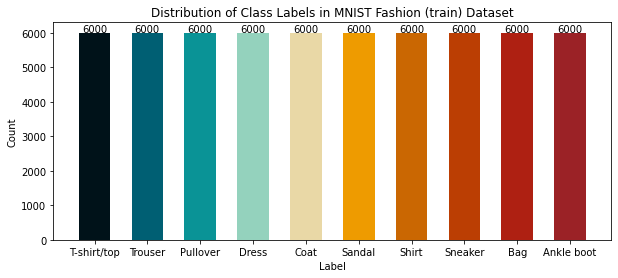

In [13]:
# plotting label distributions for training data
plot_label_distributions(train_df['LABEL'].tolist(), 'MNIST Fashion (train)', labels)

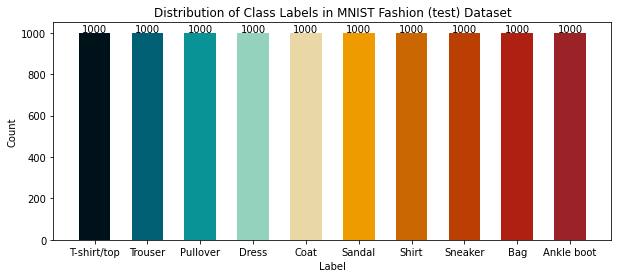

In [14]:
# plotting label distributions for testing data
plot_label_distributions(test_df['LABEL'].tolist(), 'MNIST Fashion (test)', labels)

# Implementing models

## Helper functions

## MLP

In [97]:
class NeuralNetLayer:
  def __init__(self):
    self.gradient = None
    self.parameters = None
        
  def forward(self, x):
    raise NotImplementedError

  def backward(self, gradient):
    raise NotImplementedError

In [98]:
class LinearLayer(NeuralNetLayer):
  def __init__(self, input_size, output_size):
      super().__init__()
      self.ni = input_size
      self.no = output_size

      sigma = 0.1
      self.w = sigma * random_state.randn(output_size, input_size)
      self.b = sigma * random_state.randn(output_size)
      self.cur_input = None
      self.parameters = [self.w, self.b]

  def forward(self, x):
      self.cur_input = x
      return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

  def backward(self, gradient):
      assert self.cur_input is not None, "Must call forward before backward"
      #dw = gradient.dot(self.cur_input)
      dw = gradient[:, :, None] @ self.cur_input[:, None, :]
      db = gradient
      self.gradient = [dw, db]
      return gradient.dot(self.w)

In [99]:
class ReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = np.where(x > 0, 1.0, 0.0)
    return np.maximum(0, x)

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [100]:
class LeakyReLULayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = np.where(x > 0, 1.0, 0.01)

    activated_x = [float(element) if element > 0 else float(element) * 0.01 for element in x]
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [101]:
class TanhLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
        
  def forward(self, x):
    self.gradient = [1 - element ** 2 for element in x]

    activated_x = np.tanh(x)
    return activated_x

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient * self.gradient

In [102]:
class SoftmaxOutputLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()
    self.cur_probs = None

  def forward(self, x):
    exps = np.exp(x)
    probs = exps / np.sum(exps, axis=-1)[:, None]
    self.cur_probs = probs
    return probs

  def backward(self, target):
    assert self.cur_probs is not None, "Must call forward before backward"
    return self.cur_probs - target

In [103]:
class LayerName(Enum):
  RELU = 1
  TANH = 2
  LEAKYRELU = 3

In [154]:
LayerName.RELU

LayerName.RELU


In [159]:
class MLP:
  def __init__(self, n_features, n_output, hidden_layers = 0, hidden_units = [0], activation_func: LayerName = "None"):
    layers_list = []

    # adds the input layer
    if hidden_layers == 0:
      layers_list.append(LinearLayer(n_features, n_output))
    else:
      layers_list.append(LinearLayer(n_features, hidden_units[0]))

    # adds the hidden layers
    for i in range(hidden_layers):

      # adds activation function layers
      if activation_func == "RELU":
        layers_list.append(ReLULayer())
      elif activation_func == "TANH":
        layers_list.append(TanhLayer())
      elif activation_func == "LEAKYRELU":
        layers_list.append(LeakyReLULayer())

      # if this is the last hidden layer, it outputs the output size
      if i == hidden_layers - 1:
        layers_list.append(LinearLayer(hidden_units[i], n_output))
        continue
          
      # if this is not the last hidden layer, it outputs the hidden size
      layers_list.append(LinearLayer(hidden_units[i], hidden_units[i + 1]))
          
    # adds the output layer
    layers_list.append(SoftmaxOutputLayer())

    self.layers = layers_list

  def test_func(self):
    return 5

  def forward(self, x):
    for layer in self.layers:
      x = layer.forward(x)
    return x

  def backward(self, target):
    for layer in self.layers[::-1]:
      target = layer.backward(target)

  def predict(self, x):
    return self.forward(x)

In [23]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError

class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)

# Running experiments

### Helper functions

In [53]:
def evaluate_acc(true_labels, target_labels):
  # the number of labels
  label_count = true_labels.shape[0]

  # the accuracy is the number of correctly labelled instances divided
  # by the total number of instances
  accuracy = np.sum(target_labels == true_labels) / label_count

  return accuracy

In [163]:
def train(mlp: MLP, optimizer: Optimizer, data_x, data_y, steps):
  labels_count = len(set(data_y))

  losses = []
  labels = np.eye(labels_count)[np.array(data_y)]

  if len(data_x) >= 60000:
    divider = 6000
  else:
    divider = 40

  for _ in range(steps):
    # batching (but randomly... we can fix how data is split later)
    indices = random_state.choice(len(data_x), int(len(data_x)/divider))
    batch = data_x[indices]
    batch_labels = labels[indices]
    prediction_probs = mlp.forward(batch)

    loss = -(batch_labels * np.log(prediction_probs)).sum(axis=-1).mean()
    losses.append(loss)
    mlp.backward(batch_labels)
    optimizer.step()

  # the number of hidden layers
  hidden_layer_count = int((len(mlp.layers) - 2) / 2)

  # plotting
  plt.plot(losses)
  plt.title("Cross-entropy training loss for " + str(hidden_layer_count) + " hidden layers")
  plt.xlabel("Epoch")
  plt.ylabel("Cross-entropy loss")

  return losses

In [127]:
def test(mlp: MLP, x_train, y_train, x_test, y_test, silent = True):
  train_prediction_probs = mlp.predict(x_train)
  train_predictions = np.argmax(train_prediction_probs, axis = -1)
  
  test_prediction_probs = mlp.predict(x_test)
  test_predictions = np.argmax(test_prediction_probs, axis = -1)
  
  train_acc = evaluate_acc(train_predictions, y_train)
  test_acc = evaluate_acc(test_predictions, y_test)
  
  if not silent:
    print("The accuracy of the model on the training data: " + str(round((train_acc * 100), 2)) + "%")
    print("The accuracy of the model on the testing data: " + str(round((test_acc * 100), 2)) + "%")

  return train_acc, test_acc

### Baseline accuracy tests



In [37]:
n_features_mnist = x_train.shape[-1]
n_output_mnist = len(set(y_train))

The accuracy of the model on the training data: 71.78%
The accuracy of the model on the testing data: 70.95%




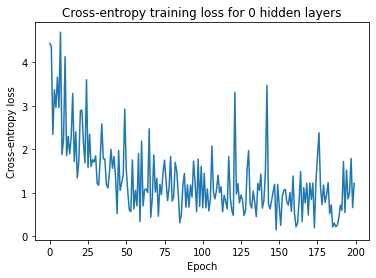

In [169]:
### training and testing 0 hidden layers

mlp0 = MLP(n_features_mnist, n_output_mnist, 0, "RELU")
opt0 = GradientDescentOptimizer(mlp0, 1e-2)

mnist_losses0 = train(mlp0, opt0, x_train, y_train, 200)
acc0 = test(mlp0, x_train, y_train, x_test, y_test, silent = False)
print("\n")

The accuracy of the model on the training data: 69.67%
The accuracy of the model on the testing data: 69.06%




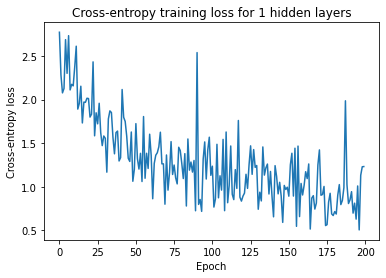

In [170]:
### training 1 hidden layer

mlp1 = MLP(n_features_mnist, n_output_mnist, 1, [32], "RELU")
opt1 = GradientDescentOptimizer(mlp1, 1e-2)

mnist_losses = train(mlp1, opt1, x_train, y_train, 200)
acc1 = test(mlp1, x_train, y_train, x_test, y_test, silent = False)
print("\n")

The accuracy of the model on the training data: 61.89%
The accuracy of the model on the testing data: 61.55%




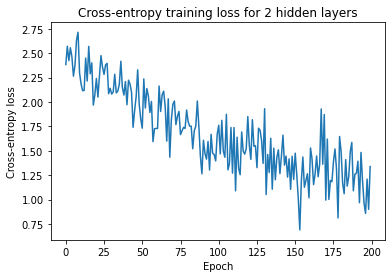

In [171]:
### testing 2 hidden layers

mlp2 = MLP(n_features_mnist, n_output_mnist, 2, [32, 32], "RELU")
opt2 = GradientDescentOptimizer(mlp2, 1e-2)

mnist_losses2 = train(mlp2, opt2, x_train, y_train, 200)
acc2 = test(mlp2, x_train, y_train, x_test, y_test, silent = False)
print("\n")